In [24]:
import pandas as pd
import numpy as np

whole_csv = pd.read_csv("biogears_py/csv/wholepsv.csv", index_col=['pid', 'time'])
whole_csv = whole_csv.groupby(level=0).filter(lambda x: (~np.isnan(x["Hgb"])).sum() > 1)
# split the whole_csv into sepsis and nonsepsis subdf
sepsis_csv = whole_csv[whole_csv["SepsisLabel"] == 1]

sepsis_pids = sepsis_csv.index.get_level_values(0).unique()
nonsepsis_pids = whole_csv.index.get_level_values(0).unique().difference(sepsis_pids)

sepsis_csv = whole_csv.loc[sepsis_pids]
nonsepsis_csv = whole_csv.loc[nonsepsis_pids]

print("sepsis patients mean feat values")
print(sepsis_csv.groupby(level=0).mean().mean())
print("nonsepsis patients mean feat values")
print(nonsepsis_csv.groupby(level=0).mean().mean())

sepsis patients mean feat values
HR                   88.079160
O2Sat                97.383183
Temp                 37.093754
SBP                 122.486741
MAP                  79.823418
DBP                  61.102890
Resp                 20.088963
EtCO2                      NaN
BaseExcess            0.248076
HCO3                 24.388207
FiO2                  0.518076
pH                    7.396990
PaCO2                40.694261
SaO2                 92.572587
AST                 195.583740
BUN                  27.874624
Alkalinephos        100.395352
Calcium               8.288680
Chloride            105.856031
Creatinine            1.508042
Bilirubin_direct      4.268908
Glucose             134.644815
Lactate               1.958995
Magnesium             2.063905
Phosphate             3.537291
Potassium             4.057154
Bilirubin_total       2.273338
TroponinI             7.072000
Hct                  30.667728
Hgb                  10.387516
PTT                  37.241225
WBC   

In [25]:
from tqdm.notebook import tqdm


def slid_convet(whole_csv, win_size, step_size):
    # slid processing over the second level of the multiindex
    # output shape: N, win_size, features
    pids = whole_csv.index.get_level_values(0).unique()
    samples = []
    labels = []
    for _id in tqdm(pids):
        subdf = whole_csv.loc[[_id]]
        t_s = 0
        while t_s + win_size  < len(subdf):
            samples_tmp = subdf.iloc[t_s:t_s + win_size]
            featcols = [col for col in samples_tmp.columns if col != "SepsisLabel"]
            samples.append(samples_tmp[featcols].values)
            labels_tmp = subdf.iloc[t_s + win_size]
            labels_tmp = labels_tmp["SepsisLabel"]
            labels.append(labels_tmp)
            t_s += step_size
    return np.array(samples), np.array(labels)

  0%|          | 0/4846 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.98      0.68      0.80     16223
         1.0       0.04      0.47      0.08       499

    accuracy                           0.67     16722
   macro avg       0.51      0.57      0.44     16722
weighted avg       0.95      0.67      0.78     16722



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

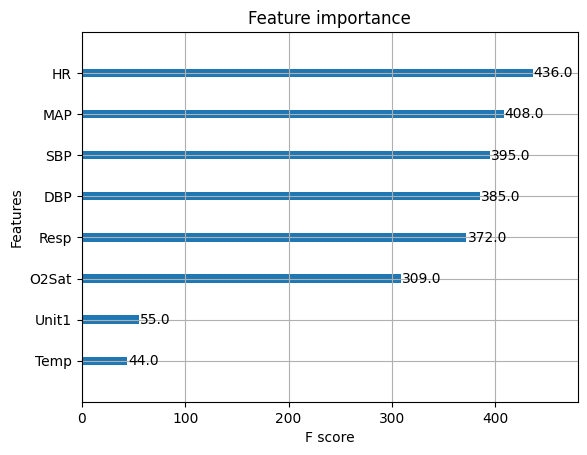

In [27]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report

samples, labels = slid_convet(whole_csv, 12, 5)

# next trying training the model using the feat max - min values
pos_samples = samples[labels == 1]
neg_samples = samples[labels == 0]

# get the max and min values of the features
max_vals = np.max(samples, axis=1)
min_vals = np.min(samples, axis=1)
maxmindiff_vals = max_vals - min_vals
wholecsvfeatcols = [col for col in whole_csv.columns if col != "SepsisLabel"]
maxmindiff_vals_df = pd.DataFrame(maxmindiff_vals, columns=wholecsvfeatcols)

# xgboost model
X_train, X_test, y_train, y_test = train_test_split(maxmindiff_vals_df, labels, test_size=0.33, random_state=42)

# balance the dataset of class sepsis 0 and sepsis 1
pos_count = np.sum(y_train).astype(int)
neg_count = len(y_train) - pos_count
# balance the dataset using subsampling
train_idxes = np.arange(len(y_train))
pos_idxes = train_idxes[y_train == 1]
neg_idxes = train_idxes[y_train == 0]
np.random.seed(42)
neg_idxes = np.random.choice(neg_idxes, pos_count, replace=False)
train_idxes = np.concatenate([pos_idxes, neg_idxes])
X_train = X_train.iloc[train_idxes]
y_train = y_train[train_idxes]

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

preds = model.predict(X_test)

print(classification_report(y_test, preds > 0.5))

# plot the feature importance
xgb.plot_importance(model)

In [4]:
# next we apply the trained hco3 fit xgboost model from biogears_py/models
# first we impute the realtime vital signs
real_time_vtcols = ["HR", "O2Sat", "Temp", "SBP", "MAP", "DBP", "Resp"]
# then load the xgboost model (json format) (model was saved using bst.save_model("biogears_py/models/bicarbonate_fit_model.json"))
model = xgb.XGBClassifier()
model.load_model("biogears_py/models/bicarbonate_fit_model.json")

real_time_vts = whole_csv[real_time_vtcols]

# then we discretize the realtime vitalsigns
real_time_vts_disc = real_time_vts.apply(lambda x: pd.qcut(x, q=[0, 0.33, 0.66, 1], labels=[0, 1, 2]), axis=0)

# ffill impute the realtime vitalsigns
real_time_vts_disc = real_time_vts_disc.groupby(level=0).ffill()

# predict the bicarbonate
bicarbonate_preds = model.predict(real_time_vts_disc)

# then we apply the bicarbonate_preds to the whole_csv
whole_csv["bicarbonate_P"] = bicarbonate_preds

In [5]:
whole_csv

HR  O2Sat   Temp    SBP    MAP   DBP   Resp  EtCO2  BaseExcess  \
pid  time                                                                     
6876 0     92.5   97.0  36.17  111.0  77.33   NaN  24.25    NaN         NaN   
     1     88.0   98.0    NaN  116.5  82.50   NaN  24.50    NaN         NaN   
     2     88.0   97.0    NaN  121.0  83.00   NaN  26.00    NaN         NaN   
     3     81.0   97.0    NaN   95.0  69.00  65.0  24.00    NaN        -6.0   
     4     79.0   97.0  35.72  108.5  71.33  61.0  21.00    NaN         NaN   
...         ...    ...    ...    ...    ...   ...    ...    ...         ...   
9265 50    89.0   95.0  36.50  112.0  70.00   NaN  21.00    NaN         NaN   
     51    93.0   96.0    NaN  118.0  72.00   NaN  19.00    NaN         NaN   
     52    93.0   97.0    NaN  115.0  72.00   NaN  20.00    NaN         NaN   
     53    86.0   98.0    NaN  120.0  77.00   NaN  12.00    NaN         NaN   
     54    84.0   98.0  36.56  118.0  75.00   NaN  12.00    NaN         NaN   

           HCO3  ...  Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  \
pid  time        ...                                                       
6876 0     19.0  ...         NaN      242.0  86.44       1    1.0    0.0   
     1      NaN  ...         NaN        NaN  86.44       1    1.0    0.0   
     2      NaN  ...         NaN        NaN  86.44       1    1.0    0.0   
     3      NaN  ...         NaN        NaN  86.44       1    1.0    0.0   
     4     19.0  ...         NaN      210.0  86.44       1    1.0    0.0   
...         ...  ...         ...        ...    ...     ...    ...    ...   
9265 50     NaN  ...         NaN        NaN  71.09       1    1.0    0.0   
     51     NaN  ...         NaN        NaN  71.09       1    1.0    0.0   
     52     NaN  ...         NaN        NaN  71.09       1    1.0    0.0   
     53     NaN  ...         NaN        NaN  71.09       1    1.0    0.0   
     54     NaN  ...         NaN        NaN  71.09       1    1.0    0.0   

           HospAdmTime  ICULOS  SepsisLabel  bicarbonate_P  
pid  time                                                   
6876 0           -0.03       2            0              0  
     1           -0.03       3            0              0  
     2           -0.03       4            0              0  
     3           -0.03       5            0              0  
     4           -0.03       6            0              0  
...                ...     ...          ...            ...  
9265 50        -243.45      51            0              0  
     51        -243.45      52            0              0  
     52        -243.45      53            0              0  
     53        -243.45      54            0              1  
     54        -243.45      55            0              1  

[300447 rows x 42 columns]

  0%|          | 0/4846 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.98      0.64      0.77     16223
         1.0       0.04      0.47      0.07       499

    accuracy                           0.63     16722
   macro avg       0.51      0.56      0.42     16722
weighted avg       0.95      0.63      0.75     16722



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

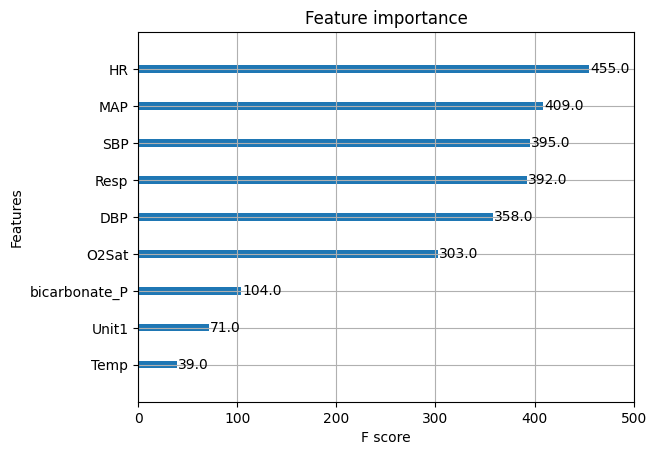

In [21]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report

samples, labels = slid_convet(whole_csv, 12, 5)

# next trying training the model using the feat max - min values
pos_samples = samples[labels == 1]
neg_samples = samples[labels == 0]

# get the max and min values of the features
max_vals = np.max(samples, axis=1)
min_vals = np.min(samples, axis=1)
maxmindiff_vals = max_vals - min_vals
wholecsvfeatcols = [col for col in whole_csv.columns if col != "SepsisLabel"]
maxmindiff_vals_df = pd.DataFrame(maxmindiff_vals, columns=wholecsvfeatcols)

# xgboost model
X_train, X_test, y_train, y_test = train_test_split(maxmindiff_vals_df, labels, test_size=0.33, random_state=42)

# balance the dataset of class sepsis 0 and sepsis 1
pos_count = np.sum(y_train).astype(int)
neg_count = len(y_train) - pos_count
# balance the dataset using subsampling
train_idxes = np.arange(len(y_train))
pos_idxes = train_idxes[y_train == 1]
neg_idxes = train_idxes[y_train == 0]
np.random.seed(42)
neg_idxes = np.random.choice(neg_idxes, pos_count, replace=False)
train_idxes = np.concatenate([pos_idxes, neg_idxes])
X_train = X_train.iloc[train_idxes]
y_train = y_train[train_idxes]

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

preds = model.predict(X_test)

print(classification_report(y_test, preds > 0.5))

# plot the feature importance
xgb.plot_importance(model)

In [22]:
# next repeat the process using linear regression
import pickle

model = pickle.load(open("biogears_py/models/bicarbonate_fit_model.pkl", "rb"))
real_time_vts_normed = (real_time_vts - real_time_vts.mean()) / real_time_vts.std()
real_time_vts_normed = real_time_vts_normed.groupby(level=0).ffill().bfill()
real_time_vts_normed = real_time_vts_normed.dropna()
bicarbonate_preds = model.predict(real_time_vts_normed)

# then we apply the bicarbonate_preds to the whole_csv
whole_csv_partial = whole_csv.loc[real_time_vts_normed.index]
whole_csv_partial["bicarbonate_P"] = bicarbonate_preds

  0%|          | 0/4845 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.98      0.57      0.72     16233
         1.0       0.04      0.54      0.07       486

    accuracy                           0.57     16719
   macro avg       0.51      0.56      0.39     16719
weighted avg       0.95      0.57      0.70     16719



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

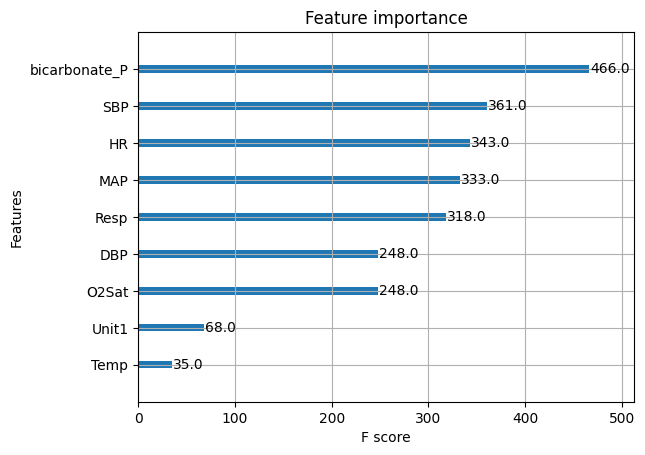

In [23]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report

samples, labels = slid_convet(whole_csv_partial, 12, 5)

# next trying training the model using the feat max - min values
pos_samples = samples[labels == 1]
neg_samples = samples[labels == 0]

# get the max and min values of the features
max_vals = np.max(samples, axis=1)
min_vals = np.min(samples, axis=1)
maxmindiff_vals = max_vals - min_vals
wholecsvfeatcols = [col for col in whole_csv_partial.columns if col != "SepsisLabel"]
maxmindiff_vals_df = pd.DataFrame(maxmindiff_vals, columns=wholecsvfeatcols)

# xgboost model
X_train, X_test, y_train, y_test = train_test_split(maxmindiff_vals_df, labels, test_size=0.33, random_state=42)

# balance the dataset of class sepsis 0 and sepsis 1
pos_count = np.sum(y_train).astype(int)
neg_count = len(y_train) - pos_count
# balance the dataset using subsampling
train_idxes = np.arange(len(y_train))
pos_idxes = train_idxes[y_train == 1]
neg_idxes = train_idxes[y_train == 0]
np.random.seed(42)
neg_idxes = np.random.choice(neg_idxes, pos_count, replace=False)
train_idxes = np.concatenate([pos_idxes, neg_idxes])
X_train = X_train.iloc[train_idxes]
y_train = y_train[train_idxes]

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

preds = model.predict(X_test)

print(classification_report(y_test, preds > 0.5))

# plot the feature importance
xgb.plot_importance(model)

# None min-max type data feature, use raw feature

In [4]:
from tqdm.notebook import tqdm


import pandas as pd
import numpy as np

whole_csv = pd.read_csv("biogears_py/csv/wholepsv.csv", index_col=['pid', 'time'])
whole_csv = whole_csv.groupby(level=0).filter(lambda x: (~np.isnan(x["Hgb"])).sum() > 1)
# split the whole_csv into sepsis and nonsepsis subdf
sepsis_csv = whole_csv[whole_csv["SepsisLabel"] == 1]

sepsis_pids = sepsis_csv.index.get_level_values(0).unique()
nonsepsis_pids = whole_csv.index.get_level_values(0).unique().difference(sepsis_pids)

sepsis_csv = whole_csv.loc[sepsis_pids]
nonsepsis_csv = whole_csv.loc[nonsepsis_pids]

print("sepsis patients mean feat values")
print(sepsis_csv.groupby(level=0).mean().mean())
print("nonsepsis patients mean feat values")
print(nonsepsis_csv.groupby(level=0).mean().mean())


def slid_convet(whole_csv, win_size, step_size):
    # slid processing over the second level of the multiindex
    # output shape: N, win_size, features
    pids = whole_csv.index.get_level_values(0).unique()
    samples = []
    labels = []
    for _id in tqdm(pids):
        subdf = whole_csv.loc[[_id]]
        t_s = 0
        while t_s + win_size + 1 < len(subdf):
            samples_tmp = subdf.iloc[t_s:t_s + win_size]
            featcols = [col for col in samples_tmp.columns if col != "SepsisLabel"]
            samples.append(samples_tmp[featcols].values)
            labels_tmp = subdf.values[t_s + win_size, -1]
            labels.append(labels_tmp)
            t_s += step_size
    return np.array(samples), np.array(labels)

sepsis patients mean feat values
HR                   88.079160
O2Sat                97.383183
Temp                 37.093754
SBP                 122.486741
MAP                  79.823418
DBP                  61.102890
Resp                 20.088963
EtCO2                      NaN
BaseExcess            0.248076
HCO3                 24.388207
FiO2                  0.518076
pH                    7.396990
PaCO2                40.694261
SaO2                 92.572587
AST                 195.583740
BUN                  27.874624
Alkalinephos        100.395352
Calcium               8.288680
Chloride            105.856031
Creatinine            1.508042
Bilirubin_direct      4.268908
Glucose             134.644815
Lactate               1.958995
Magnesium             2.063905
Phosphate             3.537291
Potassium             4.057154
Bilirubin_total       2.273338
TroponinI             7.072000
Hct                  30.667728
Hgb                  10.387516
PTT                  37.241225
WBC   

              precision    recall  f1-score   support

           0       0.98      0.61      0.75     15874
           1       0.04      0.58      0.07       434

    accuracy                           0.61     16308
   macro avg       0.51      0.59      0.41     16308
weighted avg       0.96      0.61      0.74     16308



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

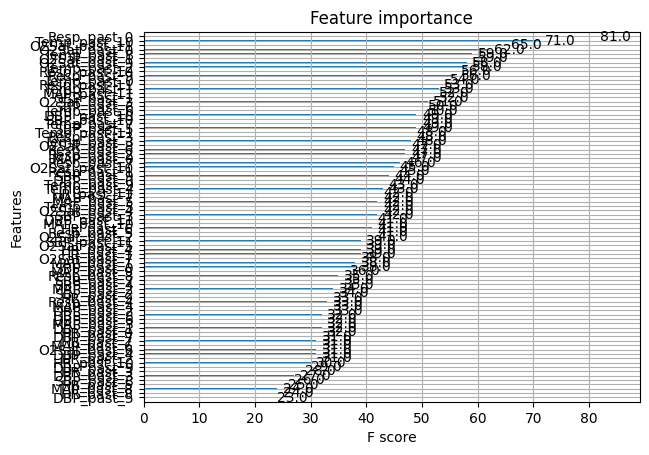

In [9]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report

# # first discretize the realtime vts
# real_time_vtcols = ["HR", "O2Sat", "Temp", "SBP", "MAP", "DBP", "Resp"]
# real_time_vts = whole_csv[real_time_vtcols]
# real_time_vts_disc = real_time_vts.apply(lambda x: pd.qcut(x, q=[0, 0.33, 0.66, 1], labels=[0, 1, 2]), axis=0)
# whole_csv_rts_disced = whole_csv.copy()
# whole_csv_rts_disced[real_time_vtcols] = real_time_vts_disc
# # takes only the real time vitalsigns
# whole_csv_rts_disced = whole_csv_rts_disced[real_time_vtcols + ["SepsisLabel"]]

# samples, labels = slid_convet(whole_csv_rts_disced, 12, 5)

# # next trying training the model using the feat max - min values
# pos_samples = samples[labels == 1]
# neg_samples = samples[labels == 0]

# # get the max and min values of the features
# wholecsvfeatcols = [col for col in whole_csv.columns if col != "SepsisLabel"]
# reshaped_feat_cols = []
# for i in range(samples.shape[1]):
#     for col in wholecsvfeatcols:
#         reshaped_feat_cols.append(f"{col}_past_{i}")

# ensemble predict
real_time_flattened_vtcols = []
for i in range(12):
    for colname in real_time_vtcols:
        real_time_flattened_vtcols.append(f"{colname}_past_{i}")

samples_df = pd.DataFrame(samples.reshape(samples.shape[0], -1), columns=real_time_flattened_vtcols)
samples_df = samples_df.astype(float)

# xgboost model
X_train, X_test, y_train, y_test = train_test_split(samples_df, labels, test_size=0.33, random_state=42)

# balance the dataset of class sepsis 0 and sepsis 1
pos_count = np.sum(y_train).astype(int)
neg_count = len(y_train) - pos_count
# balance the dataset using subsampling
train_idxes = np.arange(len(y_train))
pos_idxes = train_idxes[y_train == 1]
neg_idxes = train_idxes[y_train == 0]
np.random.seed(42)
neg_idxes = np.random.choice(neg_idxes, pos_count, replace=False)
train_idxes = np.concatenate([pos_idxes, neg_idxes])
X_train = X_train.iloc[train_idxes]
y_train = y_train[train_idxes]

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

preds = model.predict(X_test)

print(classification_report(y_test, preds > 0.5))

# plot the feature importance
xgb.plot_importance(model)

# Next raw feature added with the trained model feature knowledge

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     15874
           1       0.00      0.00      0.00       434

    accuracy                           0.97     16308
   macro avg       0.49      0.50      0.49     16308
weighted avg       0.95      0.97      0.96     16308



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

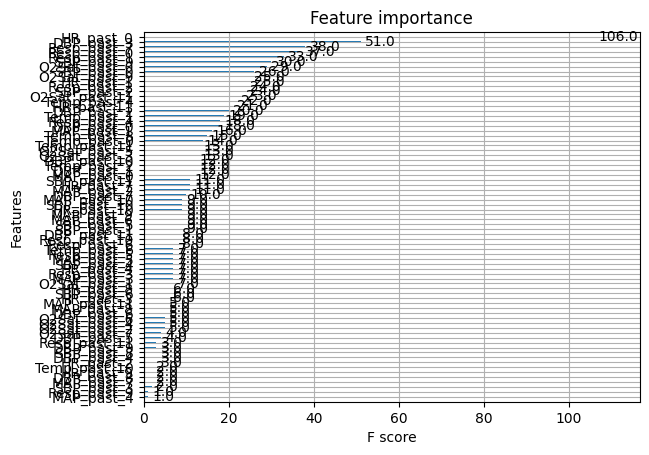

In [10]:
# load the sepsis_fit_model
model_out = xgb.XGBClassifier()
model_out.load_model("biogears_py/models/sepsis_fit_model.json")



real_time_vts_test = X_test[real_time_flattened_vtcols]
# do the prediction
pred_outermodel = model_out.predict_proba(real_time_vts_test)[:, 1]
pred_model = model.predict_proba(X_test)[:, 1]

# ensemble the prediction
pred_ensemble = (pred_outermodel + pred_model) / 2

print(classification_report(y_test, pred_ensemble > 0.5))

# print the feature importance
xgb.plot_importance(model_out)